In [1]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from scipy import stats as st
from cartopy import crs as ccrs

# dask 
from dask.diagnostics import ProgressBar

### plotting 
from matplotlib import pyplot as plt


In [2]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 


In [3]:
import sys

In [4]:
sys.path.append('../../')

In [5]:
from ICU_Water_Watch import plot, geo, utils

### directory with the daily GPM-IMERG data (one file per day )

In [6]:
dpath = pathlib.Path('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP')

In [7]:
lfiles = list(dpath.glob("GPM_IMERG_daily.v06.????.??.??.nc"))

In [8]:
lfiles.sort()

In [9]:
lfiles[0]

PosixPath('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP/GPM_IMERG_daily.v06.2001.01.01.nc')

In [10]:
lfiles[-1]

PosixPath('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP/GPM_IMERG_daily.v06.2021.09.27.nc')

In [11]:
len(lfiles)

7575

### open the multiple file dataset and selects the variable of interest 

In [12]:
dset = xr.open_mfdataset(lfiles, concat_dim='time', parallel=True)[['precipitationCal']]

### calculates the running accumulations 

### re-chunks first 

In [13]:
dset = dset.chunk({'time':-1, 'lon':10, 'lat':10})

### number of days 

In [14]:
ndays = 60

### running accumulation 

In [15]:
dset = dset.rolling({'time':ndays}, min_periods=ndays, center=False).sum('time')

In [16]:
with ProgressBar(): 
    dset = dset.compute()

[########################################] | 100% Completed | 57.7s


### get rid of the ndays - 1 first values (missing values)

In [17]:
dset = dset.isel(time=slice(ndays-1, None))

### take the month and day of the last value 

In [18]:
last_day = dset.time.to_index()[-1]

### buffer (in days) around the date (for taking the corresponding accumulations from the climatology)

In [19]:
buffer = 3

### climatological period 

In [20]:
clim_period =[2001, 2020]

## construct dates 

In [21]:
def subset_clim(dset, last_day, clim_period=[2001, 2020], buffer=3): 
    
    from datetime import datetime
    from dateutil.relativedelta import relativedelta
    import pandas as pd
    import xarray as xr 
    
    ldates = []
    for y in np.arange(clim_period[0], clim_period[-1] + 1): 
        d = datetime(y, last_day.month, last_day.day)
        d = [d + relativedelta(days=x) for x in range(-buffer, buffer+1)]
        ldates += d
    ldates = np.array(ldates)
    dates = pd.Index(ldates)
    dates = dates.to_series()
    clim = dset.sel(time=slice(*map(str, clim_period)))
    clim['time'] = clim.indexes['time'].to_datetimeindex()
    dates = dates.loc[clim.time.to_index()[0]:clim.time.to_index()[-1],]
    clim = clim.sel(time=dates.values)
    return clim

In [22]:
ldates = []
for y in np.arange(clim_period[0], clim_period[-1] + 1): 
    d = datetime(y, last_day.month, last_day.day)
    d = [d + relativedelta(days=x) for x in range(-buffer, buffer+1)]
    ldates += d

In [23]:
ldates = np.array(ldates)

In [24]:
dates = pd.Index(ldates)

In [25]:
dates = dates.to_series()

In [26]:
clim = dset.sel(time=slice(*map(str, clim_period)))

In [27]:
clim['time'] = clim.indexes['time'].to_datetimeindex()

<ipython-input-27-69a656c69746>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clim['time'] = clim.indexes['time'].to_datetimeindex()


In [28]:
dates = dates.loc[clim.time.to_index()[0]:clim.time.to_index()[-1],]

In [29]:
clim = clim.sel(time=dates.values)

In [30]:
clim.time[:5]

<xarray.DataArray 'time' (time: 5)>
array(['2001-09-24T00:00:00.000000000', '2001-09-25T00:00:00.000000000',
       '2001-09-26T00:00:00.000000000', '2001-09-27T00:00:00.000000000',
       '2001-09-28T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-09-24 2001-09-25 ... 2001-09-28

In [31]:
clim.time[-5:]

<xarray.DataArray 'time' (time: 5)>
array(['2020-09-26T00:00:00.000000000', '2020-09-27T00:00:00.000000000',
       '2020-09-28T00:00:00.000000000', '2020-09-29T00:00:00.000000000',
       '2020-09-30T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-09-26 2020-09-27 ... 2020-09-30

In [32]:
#Standardized Precipitation Index Function
def spi(ds, thresh, dimension):
    
    import numpy as np 
    import xarray as xr 
    from scipy import stats as st
    
    
    #ds - data ; thresh - time interval / scale; dimension - dimension as a string
    
    #Rolling Mean / Moving Averages
    ds_ma = ds.rolling(time = thresh, center=False).mean(dim=dimension)
    
    #Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In = ds_In.where(np.isinf(ds_In) == False) #= np.nan  #Change infinity to NaN
    
    ds_mu = ds_ma.mean(dimension)
    
    #Overall Mean of Moving Averages
    ds_mu = ds_ma.mean(dimension)
    
    #Summation of Natural log of moving averages
    ds_sum = ds_In.sum(dimension)
    
    #Computing essentials for gamma distribution
    n = ds_In[thresh-1:, :, :].count(dimension)                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha                         #Computing beta (scale)
    
    #Gamma Distribution (CDF) 
    gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)
    gamma = xr.apply_ufunc(gamma_func, ds_ma, alpha, beta)
    
    #Standardized Precipitation Index   (Inverse of CDF)
    norminv = lambda data: st.norm.ppf(data, loc=0, scale=1)
    norm_spi = xr.apply_ufunc(norminv, gamma)  #loc is mean and scale is standard dev.
    
    return ds_ma, ds_In , ds_mu, ds_sum,n, A, alpha, beta, gamma, norm_spi

In [33]:
def calibrate_SPI(dset, variable='precipitationCal', dimension='time', return_gamma = False): 
    
    import numpy as np 
    import xarray as xr 
    from scipy import stats as st
    
    ds_ma = dset[variable]
    
    ds_In = np.log(ds_ma)
    ds_In = ds_In.where(np.isinf(ds_In) == False) #= np.nan  #Change infinity to NaN

    ds_mu = ds_ma.mean(dimension)

    #Overall Mean of Moving Averages
    ds_mu = ds_ma.mean(dimension)

    #Summation of Natural log of moving averages
    ds_sum = ds_In.sum(dimension)

    #Computing essentials for gamma distribution
    n = ds_In.count(dimension)                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha            
    
    if return_gamma: 

        gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)

        gamma = xr.apply_ufunc(gamma_func, ds_ma, alpha, beta)

        return gamma, alpha, beta

    else: 
        
        return alpha, beta

In [34]:
def calculate_SPI(dataarray, alpha, beta): 
    
    import numpy as np 
    import xarray as xr 
    from scipy import stats as st
    
    gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)
    
    gamma = xr.apply_ufunc(gamma_func, dataarray, alpha, beta)
    
    norminv = lambda data: st.norm.ppf(data, loc=0, scale=1)
    
    norm_spi = xr.apply_ufunc(norminv, gamma)

In [32]:
ds_ma = clim['precipitationCal']

In [33]:
dimension='time'

In [34]:
ds_In = np.log(ds_ma)
ds_In = ds_In.where(np.isinf(ds_In) == False) #= np.nan  #Change infinity to NaN

ds_mu = ds_ma.mean(dimension)

#Overall Mean of Moving Averages
ds_mu = ds_ma.mean(dimension)

#Summation of Natural log of moving averages
ds_sum = ds_In.sum(dimension)

#Computing essentials for gamma distribution
n = ds_In.count(dimension)                  #size of data
A = np.log(ds_mu) - (ds_sum/n)             #Computing A
alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
beta = ds_mu/alpha            

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [35]:
gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)

In [36]:
gamma = xr.apply_ufunc(gamma_func, ds_ma, alpha, beta)

In [37]:
gamma_realtime = xr.apply_ufunc(gamma_func, dset['precipitationCal'][-1,:,:], alpha, beta)

In [38]:
norminv = lambda data: st.norm.ppf(data, loc=0, scale=1)

In [39]:
norm_spi = xr.apply_ufunc(norminv, gamma)

In [40]:
norm_spi_realtime = xr.apply_ufunc(norminv, gamma_realtime)

### norm_spi_realtime now a dataset, with variable name SPI 

In [41]:
norm_spi_realtime = norm_spi_realtime.to_dataset(name='SPI')

### reads in the EEZs 

In [42]:
from ICU_Water_Watch import geo

In [43]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes='/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/')

### adds the EEZ mask to the dataset 

In [44]:
norm_spi_realtime = geo.make_mask_from_gpd(norm_spi_realtime, merged_EEZs, subset=True, mask_name='EEZ')

In [45]:
from ICU_Water_Watch.plot import * 

In [46]:
thresholds = [-2.5, -2, -1.5, -1, 1, 1.5, 2, 2.5]

rgbs = ['#f54842', '#de8735', '#deb42a', '#ffffff', '#96ceff', '#4553bf', '#09146b']

ticks_marks = np.diff(np.array(thresholds)) / 2.

ticks = [thresholds[i] + ticks_marks[i] for i in range(len(thresholds) - 1)]

In [47]:
ticks

[-2.25, -1.75, -1.25, 0.0, 1.25, 1.75, 2.25]

In [48]:
cbar_kwargs={'shrink':0.5, 'pad':0.01, 'extend':'neither', 'drawedges':True, 'ticks':ticks, 'aspect':15}

In [49]:
cmap = matplotlib.colors.ListedColormap(rgbs, name='SPI')

In [50]:
dataarray = norm_spi_realtime['SPI'] * norm_spi_realtime['EEZ']

In [51]:
cbar_ticklabels = ['- extremely dry','- severely dry','- moderately dry',' ', '- moderately wet','- severely wet','- extremely wet']

In [52]:
last_day = datetime(last_day.year, last_day.month, last_day.day)

Text(0.99, 0.95, 'GPM-IMERG, Standardized Precipitation Index (SPI) \n60 days to 27 September 2021 [UTC]')

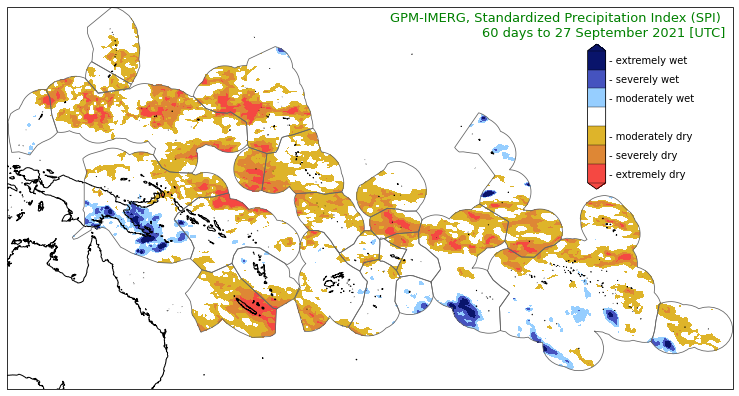

In [55]:
f, ax = plt.subplots(figsize=(13, 8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

im = dataarray.plot.contourf(ax=ax, levels=thresholds, cmap=cmap, transform=ccrs.PlateCarree(), add_colorbar=False)

# adds the colorbar axes as insets 

cbar_ax = ax.axes.inset_axes([0.80, 0.5225, 0.025, 0.38])

# plots the colorbar in these axes 

cb = plt.colorbar(im, cax=cbar_ax, **cbar_kwargs)

cb.ax.minorticks_off() 

cb.ax.tick_params(size=0)

# plots the ticklabels 

cbar_ax.set_yticklabels(cbar_ticklabels)

ax.coastlines(resolution='10m')

EEZs.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='0.4', linewidth=0.8)

title = f"GPM-IMERG, Standardized Precipitation Index (SPI) \n{ndays} days to {last_day:%d %B %Y} [UTC]"

ax.set_title("") # to get rid of the default title

ax.text(0.99, 0.95, title, fontsize=13, fontdict={'color':'green'}, bbox=dict(facecolor='w', edgecolor='w'), horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)


In [54]:
f.savefig(f'./SPI_ICU_prototype_{ndays}_days_to_{last_day:%Y%m%d}.png', dpi=200, bbox_inches='tight', facecolor='w')